# Code definition

In [5]:
import pywt
import numpy as np
from scipy import special
import copy


def is_power_of_two(n: int):
    """
    Function asserting if the integer parameter n is a power of two or not.
    Parameters
    ----------
    n: int
        Parameter to check if it is a power of two.

    Returns
    -------
    bool
    """
    if not isinstance(n, int):
        raise TypeError("n must be integer")
    elif n < 0:
        raise ValueError('n must be positive')
    return (n != 0) and (n & (n - 1) == 0)


def nearest_power_of_two(n: int, side: str = 'both'):
    """
    Function giving the nearest power of two of a given integer n.
    Parameters
    ----------
    n: int
        Parameter we want the nearest power of two.
    side: str
        On which side of the parameter we want the power of two.
        If "left", returns the nearest power of two less than n.
        If "right", returns the nearest power of two greater than n.
        If "both", returns the nearest power of two from both side (preferably the right one if same distance).

    Returns
    -------
    int
        Nearest power of two of n. Return n if n is already a power of two.
    """
    if is_power_of_two(n):
        return n
    else:
        if side == "left":
            if n == 0:
                raise ValueError("no left power of two for zero")
            else:
                start = n
                while not is_power_of_two(start):
                    start -= 1
                return start
        elif side == "right":
            start = n
            while not is_power_of_two(start):
                start += 1
            return start
        else:
            if n == 0:
                return nearest_power_of_two(n, side='right')
            else:
                left = nearest_power_of_two(n, side='left')
                right = nearest_power_of_two(n, side='right')
                if abs(left - n) >= abs(right - n):
                    return right
                else:
                    return left


def extend(signal: np.array, n: int, method: str = "sym", side: str = "both"):
    """
    Function to extend a 1D numpy array.
    Parameters
    ----------
    signal: np.array
        Signal to extend.
    n: int
        Number of points to add.
    method: str
        Method used to exted the signal. "sym" for symmetric, "cte" for constant. Default to "sym".
    side: str
        On which side to extend the signal ("left", "right" or "both"). Default to "both".

    Returns
    -------
    np.array
        Extended array.
    """
    if n < 0:
        raise ValueError("n must be > 0")
    elif method not in ['sym', 'cte']:
        raise ValueError('Wrong method')
    elif side not in ['left', 'right', 'both']:
        raise ValueError('Wrong side')

    if n > 0:
        if side == "both":
            return np.concatenate((extend(signal, n, method, 'left'), extend(signal, n, method, 'right')[len(signal):]))
        elif side == "left":
            if method == "sym":
                return np.concatenate((np.flip(signal)[-n:], signal))
            elif method == "cte":
                return np.concatenate((signal[0] * np.ones(n), signal))
        elif side == "right":
            if method == "sym":
                return np.concatenate((signal, np.flip(signal)[:n]))
            elif method == "cte":
                return np.concatenate((signal, signal[-1] * np.ones(n)))
        else:
            return signal


def std_estimation(signal: np.array, wavelet_name: str) -> float:
    """
    Estimate the standard deviation of noise of a given signal.
    Parameters
    ----------
    signal: numpy array
        Signal on wi
    wavelet_name: str
        Wavelet used to estimate the noise standard deviation.

    Returns
    -------
    float
        Estimated standard deviation of the noise.

    """
    max_level = pywt.dwt_max_level(len(signal), pywt.Wavelet(wavelet_name).dec_len)
    wavelet_decomposition = pywt.wavedec(signal, wavelet_name, mode='per', level=max_level)
    mt = np.sqrt(2) * special.erfinv(0.5)
    return np.median(np.abs(wavelet_decomposition[max_level])) / mt


def wavelet_threshold(signal: np.array, wavelet_name: str, level: int, threshold: float) -> np.array:
    """
    Function thresholding wavelet coefficients of a signal.
    Parameters
    ----------
    signal: numpy array
        Signal to threshold.
    wavelet_name: str
        Wavelet used to threshold the signal.
    level: int
        Decomposition level (must be >= 0).
        If level is None (default) then it will be calculated using the dwt_max_level function.
    threshold: float
        Threshold used to threshold the wavelets coefficients.

    Returns
    -------
    numpy array
        Thresholded signal.
    """
    wavelet_decomposition = pywt.wavedecn(signal, wavelet_name, mode='per', level=level)
    arr, coeff_slices = pywt.coeffs_to_array(wavelet_decomposition)
    arr_thresholded_coeffs = arr * (np.abs(arr) > threshold)
    coeffs_from_arr = pywt.array_to_coeffs(arr_thresholded_coeffs, coeff_slices)
    thresholded_signal = pywt.waverecn(coeffs_from_arr, wavelet_name, mode='per')
    return thresholded_signal


def basic_denoise(signal: np.array, wavelet_name: str, std: float, threshold_multiplier: int = 3,
                  translations: int = None) -> np.array:
    """
    Function to denoise a signal by thresholding wavelet coefficients with noise standard deviation.
    Possibility of meaning the result with translations.
    Parameters
    ----------
    signal: numpy array
        Signal to denoise.
    wavelet_name: str
        Wavelet used to denoise the signal.
    std: float
        Noise standard deviation.
    threshold_multiplier: int
        Coefficient used to compute the threshold (multiplies the standard deviation). Default to 3.
    translations: int
        Number of translations done to mean the result. Default to None.

    Returns
    -------
    numpy array
        Denoised signal.
    """
    if (translations != 0) and (translations is not None):
        max_level = pywt.dwt_max_level(len(signal), pywt.Wavelet(wavelet_name).dec_len)
        threshold = threshold_multiplier * std
        sum_ = 0 * signal
        result = None
        for k in np.arange(0, translations):
            temp_signal = np.roll(signal, k)
            result_temp = wavelet_threshold(temp_signal, wavelet_name, max_level, threshold)
            result_temp2 = np.roll(result_temp, -k)
            sum_ += result_temp2
            temp_signal = np.roll(signal, -k)
            result_temp = wavelet_threshold(temp_signal, wavelet_name, max_level, threshold)
            result_temp2 = np.roll(result_temp, k)
            sum_ += result_temp2
        result = sum_ / (2.0 * translations)
        return result
    else:
        max_level = pywt.dwt_max_level(len(signal), pywt.Wavelet(wavelet_name).dec_len)
        threshold = threshold_multiplier * std
        result = wavelet_threshold(signal, wavelet_name, max_level, threshold)
        return result


def denoise(signal: np.array, wavelet_name: str = 'haar', threshold: int = 3,
            translations: int = None) -> np.array:
    noised_signal = copy.deepcopy(signal)

    # wavelets denoising needs signal with a power of two length
    if not is_power_of_two(len(noised_signal)):
        nbr_points_to_add = nearest_power_of_two(len(noised_signal), side="right") - len(signal)
        noised_signal = extend(noised_signal, nbr_points_to_add, method="sym", side="right")

    # estimation of noise standard deviation
    std = std_estimation(signal, wavelet_name)

    if std == 0.0:
        std = 1.0

    # denoising
    denoised_signal = basic_denoise(noised_signal, wavelet_name, std, threshold, translations)

    # return signal of good length
    return denoised_signal[:len(signal)]


# Example on timeseries

<AxesSubplot:>

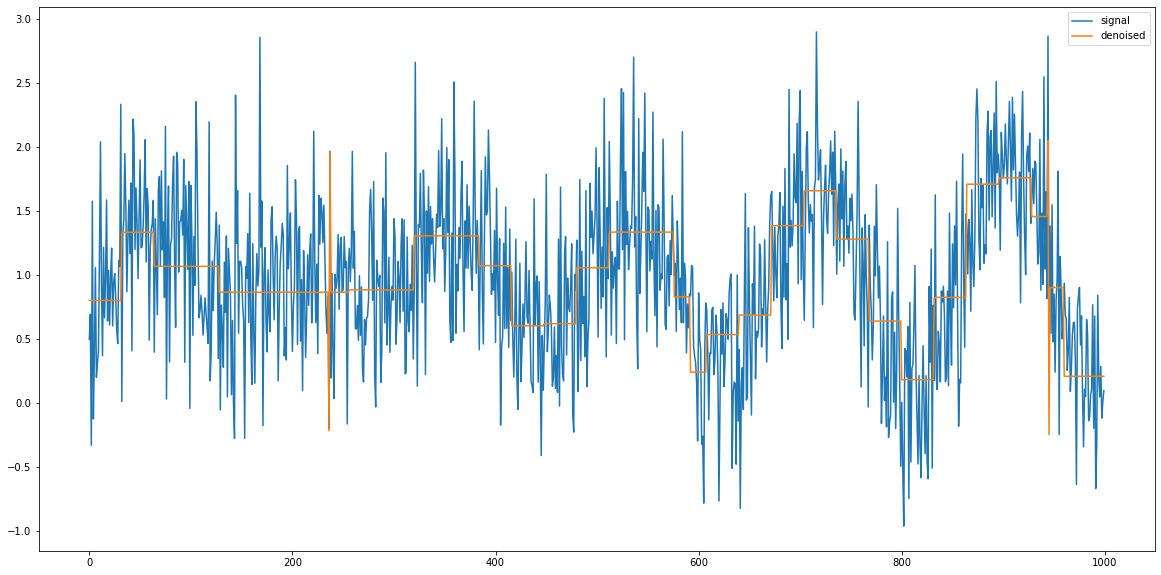

In [44]:
import numpy as np
import pandas as pd
import plotly.express as px

n = 1000
limit_low = 0
limit_high = 0.48
np.random.seed(2)
ts = np.random.normal(0, 0.5, n) + np.sin(np.linspace(0, 5*np.pi, n))**2 + np.sin(np.linspace(1, 6*np.pi, n))**2
denoised_ts = denoise(ts)

data = pd.DataFrame({"signal": ts, "denoised": denoised_ts})
data.plot(figsize=(20, 10))